In [4]:
import numpy as np
import matplotlib.pyplot as plt

from mne import Epochs, create_info, events_from_annotations
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR
from mne import read_epochs, concatenate_epochs

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [5]:
cd epochs

/Users/jang-wonjun/Documents/eeg/ml/epochs


In [6]:
ls

epoch0-epo.fif   epoch2-epo.fif   epoch5-epo.fif   epoch8-epo.fif
epoch1-epo.fif   epoch3-epo.fif   epoch6-epo.fif   epoch9-epo.fif
epoch10-epo.fif  epoch4-epo.fif   epoch7-epo.fif


In [7]:
n_epochs = 11
epoch_list = [f'epoch{i}-epo.fif' for i in range(n_epochs)]

In [8]:
epoch = concatenate_epochs([read_epochs(epoch_i) for epoch_i in epoch_list])
epoch

Reading /Users/jang-wonjun/Documents/eeg/ml/epochs/epoch0-epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jang-wonjun/Documents/eeg/ml/epochs/epoch1-epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jang-wonjun/Documents/eeg/ml/epochs/epoch2-epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jang-wonjun/Documents/eeg/ml/epochs/epoch3-epo.fif ...
    Found the data of interest:
        t =  

Number of events,110
Events,finger_movement: 110
Time range,-2.000 – 2.000 s
Baseline,off


In [9]:
model = bagging
clf = make_pipeline(
    CSP(n_components=4, reg=None, log=True, norm_trace=False),
    model,
)


NameError: name 'bagging' is not defined

In [10]:
bagging = BaggingClassifier(SVC(),max_samples=0.5,max_features=0.5)

In [11]:
svc_model = SVC(kernel='linear', C=1.0, probability=True)
xgb_model = XGBClassifier(learning_rate=0.1, n_estimators=100)
rf_model = RandomForestClassifier(n_estimators=100)

eclf = VotingClassifier(estimators=[('svc',svc_model),
                                    ('svc_bag',bagging),
                                    ('xgb',xgb_model),
                                    ('rf',rf_model)],
                                    voting='soft',
                                    weights=[1,3,5,5])
eclf_pipeline = make_pipeline(
    CSP(n_components=4, reg=None, log=True, norm_trace=False),
    eclf,
)

In [12]:
tmin, tmax = 0, 2.000
n_cycles = 10.0 
min_freq = 1.0
max_freq = 40.0
n_freqs = 10

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = tmax/10
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

In [13]:
# init scores
tf_scores = np.zeros((n_freqs - 1, n_windows))
n_splits = 3  # for cross-validation, 5 is better, here we use 3 for speed
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for freq, (fmin, fmax) in enumerate(freq_ranges):
    w_size = n_cycles / ((fmax + fmin) / 2.0)
    epoch_filter = epoch.copy().filter(fmin,fmax)
    
    for t, w_time in enumerate(centered_w_times):
        # Center the min and max of the window
        w_tmin = w_time - window_spacing / 2.0
        w_tmax = w_time + window_spacing / 2.0

        on_event = epoch_filter.copy().crop(w_tmin,w_tmax)
        off_event = epoch_filter.copy().crop(-2+w_tmin,-2+w_tmax)
        
        X = np.concatenate([on_event.get_data(),off_event.get_data()],axis=0)
        y = [1 for i in range(X.shape[0]//2)]+[0 for i in range(X.shape[0]//2)]
        tf_scores[freq, t] = np.mean(
            cross_val_score(estimator=eclf_pipeline, X=X, y=y, scoring="roc_auc", cv=cv), axis=0
        )

Setting up band-pass filter from 1 - 5.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 5.33 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.33 Hz)
- Filter length: 423 samples (3.305 s)

Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:    0.0s finished


    Using tolerance 1.4e-07 (2.2e-16 eps * 7 dim * 9.3e+07  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.1e-09 (2.2e-16 eps * 7 dim * 3.9e+06  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-09 (2.2e-16 eps * 7 dim * 4.6e+06  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7

Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-08 (2.2e-16 eps * 7 dim * 8.8e+06  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-09 (2.2e-16 eps * 7 dim * 5.9e+06  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-09 (2.2e-16 eps * 7 dim * 5.9e+06  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e

    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:    0.1s finished


Computing rank from data with rank=None
    Using tolerance 3.8e-07 (2.2e-16 eps * 7 dim * 2.4e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-07 (2.2e-16 eps * 7 dim * 1.6e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9e-07 (2.2e-16 eps * 7 dim * 2.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e-07 (2.2e-16 eps * 7 dim * 1.8e+08  max singular value)
    Estimated rank 

Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-07 (2.2e-16 eps * 7 dim * 1.6e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e-07 (2.2e-16 eps * 7 dim * 1.8e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-07 (2.2e-16 eps * 7 dim * 1.8e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:    0.1s finished


Computing rank from data with rank=None
    Using tolerance 4.8e-07 (2.2e-16 eps * 7 dim * 3.1e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-07 (2.2e-16 eps * 7 dim * 2.1e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.9e-07 (2.2e-16 eps * 7 dim * 3.1e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-07 (2.2e-16 eps * 7 dim * 2.3e+08  max singular value)
    Estimated rank 

Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-07 (2.2e-16 eps * 7 dim * 1.8e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9e-07 (2.2e-16 eps * 7 dim * 2.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-07 (2.2e-16 eps * 7 dim * 2.1e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.1e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:    0.0s finished


Computing rank from data with rank=None
    Using tolerance 2.7e-07 (2.2e-16 eps * 7 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.8e-07 (2.2e-16 eps * 7 dim * 1.8e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e-07 (2.2e-16 eps * 7 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3e-07 (2.2e-16 eps * 7 dim * 1.9e+08  max singular value)
    Estimated rank (m

Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.9e-07 (2.2e-16 eps * 7 dim * 1.9e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6e-07 (2.2e-16 eps * 7 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.1e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:    0.0s finished


Computing rank from data with rank=None
    Using tolerance 2.7e-07 (2.2e-16 eps * 7 dim * 1.7e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-07 (2.2e-16 eps * 7 dim * 1.6e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-07 (2.2e-16 eps * 7 dim * 1.6e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-07 (2.2e-16 eps * 7 dim * 1.6e+08  max singular value)
    Estimated rank 

Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:    0.1s finished


Computing rank from data with rank=None
    Using tolerance 2.5e-07 (2.2e-16 eps * 7 dim * 1.6e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 7 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank 

Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 7 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:    0.1s finished


Computing rank from data with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 7 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-07 (2.2e-16 eps * 7 dim * 1.3e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 7 dim * 1.4e+08  max singular value)
    Estimated rank 

Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 7 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 7 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:    0.1s finished


Computing rank from data with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 7 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-07 (2.2e-16 eps * 7 dim * 1.2e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-07 (2.2e-16 eps * 7 dim * 1.5e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-07 (2.2e-16 eps * 7 dim * 1.3e+08  max singular value)
    Estimated rank (m

Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2e-07 (2.2e-16 eps * 7 dim * 1.3e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 7 dim * 1.4e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-07 (2.2e-16 eps * 7 dim * 1.3e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 770 out of 770 | elapsed:    0.0s finished


Computing rank from data with rank=None
    Using tolerance 2e-07 (2.2e-16 eps * 7 dim * 1.3e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-07 (2.2e-16 eps * 7 dim * 1.1e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-07 (2.2e-16 eps * 7 dim * 1.2e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-07 (2.2e-16 eps * 7 dim * 1.1e+08  max singular value)
    Estimated rank (m

Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-07 (2.2e-16 eps * 7 dim * 1.1e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-07 (2.2e-16 eps * 7 dim * 1.2e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-07 (2.2e-16 eps * 7 dim * 1.2e+08  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


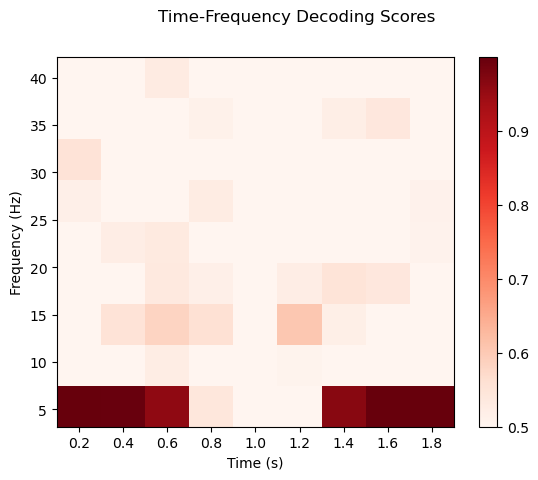

[<Figure size 640x480 with 2 Axes>]

In [14]:
# Set up time frequency object
sfreq = epoch.info["sfreq"]
av_tfr = AverageTFR(
    create_info(["freq"], sfreq),
    tf_scores[np.newaxis, :],
    centered_w_times,
    freqs[1:],
    1,
)

chance = np.mean(y)  # set chance level to white in the plot
av_tfr.plot([0], vmin=chance, title="Time-Frequency Decoding Scores", cmap=plt.cm.Reds)

In [18]:
tf_scores.flatten().max()

0.9997565132700267